In [1]:
# import networkx as nx
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time

%matplotlib inline
plt.style.use('ggplot')
sns.set()

In [2]:
# 对称检查函数
def check_symmetric(a, tol=1e-8):
    return np.allclose(a, a.T, atol=tol)

In [3]:
# 网络数据导入为numpy数组
dataFile_1 = '../data/WS_2000_4_03.mat'
data_1 = scio.loadmat(dataFile_1)
network_scale_1 = data_1['A'].shape
network_physical = np.array(data_1['A'])
# network_physical = nx.Graph(data['A'])

dataFile_2 = '../data/WS_2000_4_03_add_400_edges.mat'
data_2 = scio.loadmat(dataFile_2)
network_scale_2  = data_2['B'].shape
network_information = np.array(data_2['B'])
# network_information = nx.Graph(data['A'])

# 数据检查
assert network_scale_1 == network_scale_2, "networks\' size don\'t match!"
assert check_symmetric(network_physical), "network_physical doesn\'t symmetry!"
assert check_symmetric(network_information), "network_information doesn\'t symmetry!"
if np.sum(np.sum(network_physical, axis=0)==0):
    print("The network is integral")

In [4]:
# 参数设置

random.seed(256)
np.random.seed(256)    #指定生成“特定”的随机数

# 5. 阈值信息
batas = [0.10, 0.12, 0.14, 0.16, 0.18, 0.20, \
         0.22, 0.24, 0.26, 0.28, 0.30, 0.32, 0.34, 0.36, 0.38, 0.40, \
         0.42, 0.44, 0.46, 0.48, 0.50, 0.52, 0.54, 0.56, 0.58, 0.60, \
         0.62, 0.64, 0.66, 0.68, 0.70, 0.72, 0.74, 0.76, 0.78, 0.80,\
         0.82, 0.84, 0.86, 0.88, 0.90, 0.92, 0.94, 0.96, 0.98, 1.0]
i_beta_22_08 = np.zeros([len(batas)])

In [5]:
time_start_outter = time.time()

for b in range(len(batas)):
    bata = batas[b]
    
    # 0. 公共参数
    Monte_Carlo_loop = 50    # 蒙特卡洛模拟次数
    time_steps = 100    # 总时间步数
    N = network_scale_1[0]    # 网络节点数

    # 1. SIS参数
    # bata = 0.2    # 感染概率
    mu = 0.4    # 恢复概率

    Nodes_SIS = np.zeros([Monte_Carlo_loop, time_steps, N])    # N行代表时间步数，T列代表节点数，记录每步所有节点的感染状态

    infective_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步感染节点数,用于最终统计
    infective_count_average = np.zeros([1, time_steps])

    # 2. UAU参数
    lamda = 0.3    # 传播率
    delta = 0.6    # 遗忘率

    Nodes_UAU = np.zeros([Monte_Carlo_loop, time_steps, N])    # 存储网络中每个节点的知情状态快照

    awareness_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
    awareness_count_average = np.zeros([1, time_steps])

    # 3. 节点警觉状态
    alert = 0.8
    inalert = 1 - alert

    Node_alert = np.zeros([Monte_Carlo_loop, time_steps, N])    # 存储网络中每个节点的活跃状态快照
    alert_count = np.zeros([Monte_Carlo_loop, time_steps])    # 每步知晓节点数量,用于最终统计
    alert_count_average = np.zeros([1, time_steps])

    # 4. 其他参数
    aplha = 0.4    # 信息上传率
    sigma_S = 0.5    # S节点在知道信息后的防御系数/感染率衰减, 相当于减少与周围人的接触
    
    
    time_start_inner = time.time()
    for loop in range(Monte_Carlo_loop):

        # 是否必要选择一定比例节点用于初始化
        p = random.randint(0, N-1)    # 初始始随机选出一个感染节点，四舍五入
        Nodes_SIS[loop, 0, p] = 1    # 第一步标出初始感染节点的位置
        Nodes_UAU[loop, 0, p] = 1    # 随机初始化一个节点使其处于感染状态，当前可感染状态节点的快照

        # 初始节点依概率变得警觉
        p0 = np.random.rand(1)
        if p0 < alert:
            Node_alert[loop, 0, p] = 1    # 初始节点变得警觉


        # ----------开始时间步数模拟----------
        for t in range(time_steps-1):

            # ----------UAU演化----------
            for i in range(N):

                # 如果节点i是未知节点
                if Nodes_UAU[loop, t, i] == 0:
                    neighbor_total = np.where((network_information[i, :] == 1))[0]    # 查找其邻居
                    awareness_nodes = np.where((Nodes_UAU[loop, t, :] == 1))[0]    # 查找传播节点
                    neighbor_listener = np.intersect1d(awareness_nodes, neighbor_total)    # 取交集，真正可以传播它的邻居
                    Num_neighbor_listener = len(neighbor_listener)    # 统计数量

                    # -----UAU传播过程-----
                    aware_rate = lamda
                    aware_temp = (1 - aware_rate) ** Num_neighbor_listener    # 最终计算的传播率
                    a1 = 1 - aware_temp

                    p = np.random.rand(1)
                    # 传播成功
                    if p <= a1:
                        Nodes_UAU[loop, t+1, i] = 1

                        # 已知的节点如果是非警觉的，节点依概率变得警觉
                        if Node_alert[loop, t, i] == 0:
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1
                            else:
                                Node_alert[loop, t+1, i] = 0
                        # 已知的节点如果是警觉的，保持警觉
                        elif Node_alert[loop, t, i] == 1:
                            Node_alert[loop, t+1, i] = 1
                        else:
                            print("There is an accidence in A1!")

                    # 传播失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 0

                        # 继续保持U的节点如果是警觉的，节点依概率变得非警觉
                        if Node_alert[loop, t, i] == 1:
                            p = np.random.rand(1)
                            if p < inalert:
                                Node_alert[loop, t+1, i] = 0
                            else:
                                Node_alert[loop, t+1, i] = 1
                        # 已知的节点如果是非警觉的，保持非警觉
                        elif Node_alert[loop, t, i] == 0:
                            Node_alert[loop, t+1, i] = 0
                        else:
                            print("There is an accidence in A2!")


                # -----UAU遗忘过程-----
                elif Nodes_UAU[loop, t, i] == 1:

                    p = np.random.rand(1)
                    # 遗忘成功
                    if p <= delta:
                        Nodes_UAU[loop, t+1, i] = 0    # 这个节点遗忘

                        # 遗忘的节点如果是警觉的，节点依概率变得非警觉
                        if Node_alert[loop, t, i] == 1:
                            p = np.random.rand(1)
                            if p < inalert:
                                Node_alert[loop, t+1, i] = 0
                            else:
                                Node_alert[loop, t+1, i] = 1
                        # 遗忘的节点如果是非警觉的，保持非警觉
                        elif Node_alert[loop, t, i] == 0:
                            Node_alert[loop, t+1, i] = 0
                        else:
                            print("There is an accidence in A3!")

                    # 遗忘失败
                    else:
                        Nodes_UAU[loop, t+1, i] = 1    # 遗忘失败，下个时刻节点保持知觉

                        # 遗忘失败且非警觉，依旧有概率变为警觉
                        if Node_alert[loop, t, i] == 0:
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1
                            else:
                                Node_alert[loop, t+1, i] = 0
                        # 遗忘失败且已经警觉，警觉性保持不变（只有A->U才会变化） 
                        elif Node_alert[loop, t, i] == 1:
                            Node_alert[loop, t+1, i] = 1
                        else:
                            print("There is an accidence in A4!")   


            # ----------SIS演化----------
            for i in range(N):

                # 0代表易感(S)，如果节点i健康且非警觉，就查找其I状态的邻居（非警觉节点处理方式不变-与所有结节点触）
                if ((Nodes_SIS[loop, t, i] == 0) and (Node_alert[loop, t, i] == 0)):

                    neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 查找感染节点
                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)    # 取交集，真正可以感染它的邻居
                    Num_neighbor_infective = len(neighbor_infective)    # 统计数量

                    infect_rate_current = bata    # 当前临时感染率
                    rate_temp = 1    # 用于计算感染率

                    # SIS感染率改变规则
                    # 非知觉节点
                    if Nodes_UAU[loop, t, i] == 0:
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective                 
                    # 知觉节点
                    elif Nodes_UAU[loop, t, i] == 1:
                        infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective


                    # -----SIS感染过程1-----
                    v1 = 1 - rate_temp    # 最终计算的感染率
                    p = np.random.rand(1)
                    if p <= v1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1

                            # 成功感染的节点下一时刻依概率变得警觉
                            p = np.random.rand(1)
                            if p < alert:
                                Node_alert[loop, t+1, i] = 1    # 这个节点变得警觉
                            else:
                                Node_alert[loop, t+1, i] = 0
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                # 0代表易感(S)，如果节点i健康且警觉，就查找其I状态的警觉邻居
                elif ((Nodes_SIS[loop, t, i] == 0) and (Node_alert[loop, t, i] == 1)):

                    neighbor_total = np.where((network_physical[i, :] == 1))[0]    # 查找其邻居
                    infective_nodes = np.where((Nodes_SIS[loop, t, :] == 1))[0]    # 感染节点
                    alert_nodes = np.where((Node_alert[loop, t, :] == 0))[0]    # 警觉节点

                    neighbor_infective = np.intersect1d(infective_nodes, neighbor_total)    # 取交集，真正可以感染它的邻居
                    neighbor_infective_alert = np.intersect1d(neighbor_infective, alert_nodes)    # 取交集，真正可以感染它的警觉邻居

                    Num_neighbor_infective_alert = len(neighbor_infective_alert)    # 统计

                    infect_rate_current = bata    # 当前临时感染率
                    rate_temp = 1    # 用于计算感染率

                    # SIS感染率改变规则
                    # 非知觉节点
                    if Nodes_UAU[loop, t, i] == 0:
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_alert                 
                    # 知觉节点
                    elif Nodes_UAU[loop, t, i] == 1:
                        infect_rate_current = infect_rate_current * sigma_S    # 当前临时感染率
                        rate_temp = (1 - infect_rate_current) ** Num_neighbor_infective_alert


                    # -----SIS感染过程2-----
                    v1 = 1 - rate_temp    # 最终计算的感染率
                    p = np.random.rand(1)
                    if p <= v1:
                        Nodes_SIS[loop, t+1, i] = 1

                        # 感染节点信息上传(知晓)
                        p = np.random.rand(1)
                        if  p <= aplha:
                            Nodes_UAU[loop, t+1, i] = 1
                        else:
                            Nodes_UAU[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 0

                    # S节点已经是警觉节点，被感染后继续保持警觉
                    Node_alert[loop, t+1, i] = 1    # 这个节点变得警觉

                # -----SIS康复过程-----
                elif Nodes_SIS[loop, t, i] == 1:

                    recover_rate_current = mu
                    p = np.random.rand(1) 
                    if p <= recover_rate_current:
                        Nodes_SIS[loop, t+1, i] = 0
                    else:
                        Nodes_SIS[loop, t+1, i] = 1

                else:
                    print("There is an else condition in SIS!")
            
        print("    loop_MC {} - time has passed: {} ".format(loop, time.time()-time_start_inner))

    # 处理数据
    for loop_ in range(Monte_Carlo_loop):
        infective_count[loop_,:] = np.sum(Nodes_SIS[loop_,:,:], axis=1)
#         awareness_count[loop_,:] = np.sum(Nodes_UAU[loop_,:,:], axis=1)
#         alert_count[loop_,:] = np.sum(Node_alert[loop_,:,:], axis=1)

    infective_count_average = np.mean(infective_count, axis=0)
#     awareness_count_average = np.mean(awareness_count, axis=0)
#     alert_count_average = np.mean(alert_count, axis=0)

    assert infective_count_average.shape == (time_steps,), "infective_count_average\'s size don\'t match!"
#     assert awareness_count_average.shape == (time_steps,), "awareness_count_average\'s size don\'t match!"
#     assert alert_count_average.shape == (time_steps,), "alert_count_average\'s size don\'t match!"
    
    i_beta = infective_count_average/N
    i_beta_22_08[b] = i_beta[99]
    
    print("loop_b {} - time has passed: {} ".format(b, time.time()-time_start_outter))

    loop_MC 0 - time has passed: 72.68365859985352 
    loop_MC 1 - time has passed: 144.63428235054016 
    loop_MC 2 - time has passed: 215.03179502487183 
    loop_MC 3 - time has passed: 283.76538014411926 
    loop_MC 4 - time has passed: 353.04471468925476 
    loop_MC 5 - time has passed: 410.9157409667969 
    loop_MC 6 - time has passed: 479.4940631389618 
    loop_MC 7 - time has passed: 547.7691776752472 
    loop_MC 8 - time has passed: 616.2358505725861 
    loop_MC 9 - time has passed: 684.5159156322479 
    loop_MC 10 - time has passed: 753.3848083019257 
    loop_MC 11 - time has passed: 822.4441545009613 
    loop_MC 12 - time has passed: 891.778311252594 
    loop_MC 13 - time has passed: 948.6668467521667 
    loop_MC 14 - time has passed: 1016.6942021846771 
    loop_MC 15 - time has passed: 1084.1000576019287 
    loop_MC 16 - time has passed: 1153.1938831806183 
    loop_MC 17 - time has passed: 1220.3812749385834 
    loop_MC 18 - time has passed: 1288.8953258991

    loop_MC 1 - time has passed: 124.3309326171875 
    loop_MC 2 - time has passed: 191.9040310382843 
    loop_MC 3 - time has passed: 258.81792879104614 
    loop_MC 4 - time has passed: 326.3595886230469 
    loop_MC 5 - time has passed: 393.71134305000305 
    loop_MC 6 - time has passed: 461.723876953125 
    loop_MC 7 - time has passed: 530.1589448451996 
    loop_MC 8 - time has passed: 586.8804666996002 
    loop_MC 9 - time has passed: 655.6449749469757 
    loop_MC 10 - time has passed: 712.7504501342773 
    loop_MC 11 - time has passed: 782.4624817371368 
    loop_MC 12 - time has passed: 850.2382323741913 
    loop_MC 13 - time has passed: 917.2988638877869 
    loop_MC 14 - time has passed: 984.6228263378143 
    loop_MC 15 - time has passed: 1052.5592262744904 
    loop_MC 16 - time has passed: 1120.7549555301666 
    loop_MC 17 - time has passed: 1188.3288614749908 
    loop_MC 18 - time has passed: 1256.1635751724243 
    loop_MC 19 - time has passed: 1323.98789048194

    loop_MC 3 - time has passed: 270.2525463104248 
    loop_MC 4 - time has passed: 338.04292345046997 
    loop_MC 5 - time has passed: 405.6182949542999 
    loop_MC 6 - time has passed: 473.3624713420868 
    loop_MC 7 - time has passed: 540.8019633293152 
    loop_MC 8 - time has passed: 608.6501598358154 
    loop_MC 9 - time has passed: 676.4697308540344 
    loop_MC 10 - time has passed: 744.2776927947998 
    loop_MC 11 - time has passed: 811.124514579773 
    loop_MC 12 - time has passed: 878.8042850494385 
    loop_MC 13 - time has passed: 946.7955474853516 
    loop_MC 14 - time has passed: 1014.3009045124054 
    loop_MC 15 - time has passed: 1083.0565214157104 
    loop_MC 16 - time has passed: 1150.981154203415 
    loop_MC 17 - time has passed: 1218.0588159561157 
    loop_MC 18 - time has passed: 1283.823002576828 
    loop_MC 19 - time has passed: 1351.4357466697693 
    loop_MC 20 - time has passed: 1419.28915143013 
    loop_MC 21 - time has passed: 1487.39431476593

    loop_MC 5 - time has passed: 407.78022956848145 
    loop_MC 6 - time has passed: 475.5623450279236 
    loop_MC 7 - time has passed: 531.0162756443024 
    loop_MC 8 - time has passed: 599.3235974311829 
    loop_MC 9 - time has passed: 667.5542142391205 
    loop_MC 10 - time has passed: 735.2760248184204 
    loop_MC 11 - time has passed: 802.7203688621521 
    loop_MC 12 - time has passed: 869.9733204841614 
    loop_MC 13 - time has passed: 937.9479622840881 
    loop_MC 14 - time has passed: 1007.2380592823029 
    loop_MC 15 - time has passed: 1074.3426253795624 
    loop_MC 16 - time has passed: 1143.1563374996185 
    loop_MC 17 - time has passed: 1210.5820438861847 
    loop_MC 18 - time has passed: 1278.3918869495392 
    loop_MC 19 - time has passed: 1345.5504086017609 
    loop_MC 20 - time has passed: 1414.3491623401642 
    loop_MC 21 - time has passed: 1482.1169176101685 
    loop_MC 22 - time has passed: 1549.583654165268 
    loop_MC 23 - time has passed: 1617.417

    loop_MC 7 - time has passed: 545.3808236122131 
    loop_MC 8 - time has passed: 613.0457842350006 
    loop_MC 9 - time has passed: 669.4997889995575 
    loop_MC 10 - time has passed: 736.9210007190704 
    loop_MC 11 - time has passed: 805.2341377735138 
    loop_MC 12 - time has passed: 872.0323483943939 
    loop_MC 13 - time has passed: 940.6860129833221 
    loop_MC 14 - time has passed: 1007.841153383255 
    loop_MC 15 - time has passed: 1075.02925491333 
    loop_MC 16 - time has passed: 1142.2508869171143 
    loop_MC 17 - time has passed: 1210.2844018936157 
    loop_MC 18 - time has passed: 1276.6064348220825 
    loop_MC 19 - time has passed: 1344.73175740242 
    loop_MC 20 - time has passed: 1412.8272793293 
    loop_MC 21 - time has passed: 1480.2369930744171 
    loop_MC 22 - time has passed: 1548.292785167694 
    loop_MC 23 - time has passed: 1616.906004667282 
    loop_MC 24 - time has passed: 1685.1963665485382 
    loop_MC 25 - time has passed: 1753.304021358

    loop_MC 9 - time has passed: 678.6849365234375 
    loop_MC 10 - time has passed: 746.3272178173065 
    loop_MC 11 - time has passed: 814.2937896251678 
    loop_MC 12 - time has passed: 882.2983391284943 
    loop_MC 13 - time has passed: 949.9347860813141 
    loop_MC 14 - time has passed: 1017.8926291465759 
    loop_MC 15 - time has passed: 1085.5005385875702 
    loop_MC 16 - time has passed: 1153.0366806983948 
    loop_MC 17 - time has passed: 1219.7304706573486 
    loop_MC 18 - time has passed: 1286.753530740738 
    loop_MC 19 - time has passed: 1354.7969069480896 
    loop_MC 20 - time has passed: 1422.576183795929 
    loop_MC 21 - time has passed: 1490.5923974514008 
    loop_MC 22 - time has passed: 1557.983605146408 
    loop_MC 23 - time has passed: 1625.4969053268433 
    loop_MC 24 - time has passed: 1693.327385187149 
    loop_MC 25 - time has passed: 1760.690410375595 
    loop_MC 26 - time has passed: 1827.466866493225 
    loop_MC 27 - time has passed: 1895.1

    loop_MC 11 - time has passed: 810.4818494319916 
    loop_MC 12 - time has passed: 877.6655752658844 
    loop_MC 13 - time has passed: 945.1480309963226 
    loop_MC 14 - time has passed: 1012.9660611152649 
    loop_MC 15 - time has passed: 1080.481155872345 
    loop_MC 16 - time has passed: 1148.6555771827698 
    loop_MC 17 - time has passed: 1215.8953940868378 
    loop_MC 18 - time has passed: 1283.5501470565796 
    loop_MC 19 - time has passed: 1350.8566544055939 
    loop_MC 20 - time has passed: 1418.1201457977295 
    loop_MC 21 - time has passed: 1485.5656797885895 
    loop_MC 22 - time has passed: 1553.1750359535217 
    loop_MC 23 - time has passed: 1620.4674894809723 
    loop_MC 24 - time has passed: 1687.9059538841248 
    loop_MC 25 - time has passed: 1755.977590084076 
    loop_MC 26 - time has passed: 1823.5149450302124 
    loop_MC 27 - time has passed: 1892.0849990844727 
    loop_MC 28 - time has passed: 1959.3663575649261 
    loop_MC 29 - time has passed:

    loop_MC 13 - time has passed: 946.0329551696777 
    loop_MC 14 - time has passed: 1012.8896899223328 
    loop_MC 15 - time has passed: 1080.2673165798187 
    loop_MC 16 - time has passed: 1147.7180933952332 
    loop_MC 17 - time has passed: 1215.1708979606628 
    loop_MC 18 - time has passed: 1282.9219465255737 
    loop_MC 19 - time has passed: 1350.6485259532928 
    loop_MC 20 - time has passed: 1418.264961719513 
    loop_MC 21 - time has passed: 1486.129872560501 
    loop_MC 22 - time has passed: 1555.1891305446625 
    loop_MC 23 - time has passed: 1622.7024092674255 
    loop_MC 24 - time has passed: 1690.7027974128723 
    loop_MC 25 - time has passed: 1758.1851601600647 
    loop_MC 26 - time has passed: 1825.8329286575317 
    loop_MC 27 - time has passed: 1893.5016133785248 
    loop_MC 28 - time has passed: 1961.2883341312408 
    loop_MC 29 - time has passed: 2029.052744626999 
    loop_MC 30 - time has passed: 2096.5151064395905 
    loop_MC 31 - time has passed

    loop_MC 15 - time has passed: 1066.2339084148407 
    loop_MC 16 - time has passed: 1133.4780595302582 
    loop_MC 17 - time has passed: 1201.0661001205444 
    loop_MC 18 - time has passed: 1268.6873438358307 
    loop_MC 19 - time has passed: 1335.741775751114 
    loop_MC 20 - time has passed: 1403.3585557937622 
    loop_MC 21 - time has passed: 1471.0333409309387 
    loop_MC 22 - time has passed: 1538.547471523285 
    loop_MC 23 - time has passed: 1605.9703278541565 
    loop_MC 24 - time has passed: 1674.132482290268 
    loop_MC 25 - time has passed: 1742.377776145935 
    loop_MC 26 - time has passed: 1809.9117879867554 
    loop_MC 27 - time has passed: 1877.5654864311218 
    loop_MC 28 - time has passed: 1945.0681357383728 
    loop_MC 29 - time has passed: 2012.0774793624878 
    loop_MC 30 - time has passed: 2078.985305070877 
    loop_MC 31 - time has passed: 2145.955175638199 
    loop_MC 32 - time has passed: 2213.40917301178 
    loop_MC 33 - time has passed: 22

    loop_MC 17 - time has passed: 1207.5418150424957 
    loop_MC 18 - time has passed: 1274.6992363929749 
    loop_MC 19 - time has passed: 1341.5099761486053 
    loop_MC 20 - time has passed: 1408.2289810180664 
    loop_MC 21 - time has passed: 1475.8396894931793 
    loop_MC 22 - time has passed: 1543.1043767929077 
    loop_MC 23 - time has passed: 1609.7923574447632 
    loop_MC 24 - time has passed: 1677.5003201961517 
    loop_MC 25 - time has passed: 1744.4241852760315 
    loop_MC 26 - time has passed: 1811.1219563484192 
    loop_MC 27 - time has passed: 1877.8720376491547 
    loop_MC 28 - time has passed: 1945.7007579803467 
    loop_MC 29 - time has passed: 2012.3443522453308 
    loop_MC 30 - time has passed: 2079.2819509506226 
    loop_MC 31 - time has passed: 2146.466166496277 
    loop_MC 32 - time has passed: 2214.21964097023 
    loop_MC 33 - time has passed: 2281.314159631729 
    loop_MC 34 - time has passed: 2348.419350862503 
    loop_MC 35 - time has passed:

    loop_MC 19 - time has passed: 1343.793408870697 
    loop_MC 20 - time has passed: 1410.7091598510742 
    loop_MC 21 - time has passed: 1477.220948457718 
    loop_MC 22 - time has passed: 1544.1741619110107 
    loop_MC 23 - time has passed: 1611.3436369895935 
    loop_MC 24 - time has passed: 1678.1745398044586 
    loop_MC 25 - time has passed: 1744.7364411354065 
    loop_MC 26 - time has passed: 1812.034986257553 
    loop_MC 27 - time has passed: 1879.2550115585327 
    loop_MC 28 - time has passed: 1945.8935990333557 
    loop_MC 29 - time has passed: 2013.3769426345825 
    loop_MC 30 - time has passed: 2080.6720786094666 
    loop_MC 31 - time has passed: 2147.5968945026398 
    loop_MC 32 - time has passed: 2214.3440766334534 
    loop_MC 33 - time has passed: 2281.6119825839996 
    loop_MC 34 - time has passed: 2348.7050206661224 
    loop_MC 35 - time has passed: 2415.690262556076 
    loop_MC 36 - time has passed: 2482.910932779312 
    loop_MC 37 - time has passed:

    loop_MC 21 - time has passed: 1477.2489578723907 
    loop_MC 22 - time has passed: 1544.8815121650696 
    loop_MC 23 - time has passed: 1611.8549418449402 
    loop_MC 24 - time has passed: 1678.7767298221588 
    loop_MC 25 - time has passed: 1746.7339310646057 
    loop_MC 26 - time has passed: 1813.7846095561981 
    loop_MC 27 - time has passed: 1880.7796354293823 
    loop_MC 28 - time has passed: 1948.0031335353851 
    loop_MC 29 - time has passed: 2015.4820973873138 
    loop_MC 30 - time has passed: 2083.028704404831 
    loop_MC 31 - time has passed: 2150.291673183441 
    loop_MC 32 - time has passed: 2217.3996510505676 
    loop_MC 33 - time has passed: 2284.6405234336853 
    loop_MC 34 - time has passed: 2352.1230680942535 
    loop_MC 35 - time has passed: 2419.748417854309 
    loop_MC 36 - time has passed: 2487.35852766037 
    loop_MC 37 - time has passed: 2554.707864999771 
    loop_MC 38 - time has passed: 2621.374993801117 
    loop_MC 39 - time has passed: 2

    loop_MC 23 - time has passed: 1371.7226779460907 
    loop_MC 24 - time has passed: 1425.5810623168945 
    loop_MC 25 - time has passed: 1479.2339928150177 
    loop_MC 26 - time has passed: 1532.920030117035 
    loop_MC 27 - time has passed: 1586.4907855987549 
    loop_MC 28 - time has passed: 1640.138839483261 
    loop_MC 29 - time has passed: 1694.0191781520844 
    loop_MC 30 - time has passed: 1747.5028836727142 
    loop_MC 31 - time has passed: 1800.843317747116 
    loop_MC 32 - time has passed: 1854.9268214702606 
    loop_MC 33 - time has passed: 1908.6504001617432 
    loop_MC 34 - time has passed: 1962.3729176521301 
    loop_MC 35 - time has passed: 2016.04727768898 
    loop_MC 36 - time has passed: 2069.888466358185 
    loop_MC 37 - time has passed: 2123.571797609329 
    loop_MC 38 - time has passed: 2177.8419482707977 
    loop_MC 39 - time has passed: 2231.3757650852203 
    loop_MC 40 - time has passed: 2285.04686832428 
    loop_MC 41 - time has passed: 233

    loop_MC 24 - time has passed: 1288.8973033428192 
    loop_MC 25 - time has passed: 1331.460541009903 
    loop_MC 26 - time has passed: 1372.3202068805695 
    loop_MC 27 - time has passed: 1415.2423493862152 
    loop_MC 28 - time has passed: 1459.805316209793 
    loop_MC 29 - time has passed: 1502.337243795395 
    loop_MC 30 - time has passed: 1545.1332907676697 
    loop_MC 31 - time has passed: 1587.72629570961 
    loop_MC 32 - time has passed: 1629.5547528266907 
    loop_MC 33 - time has passed: 1670.8669428825378 
    loop_MC 34 - time has passed: 1712.366719007492 
    loop_MC 35 - time has passed: 1754.399049282074 
    loop_MC 36 - time has passed: 1795.4136533737183 
    loop_MC 37 - time has passed: 1840.445330619812 
    loop_MC 38 - time has passed: 1881.506787776947 
    loop_MC 39 - time has passed: 1922.5543463230133 
    loop_MC 40 - time has passed: 1965.4722263813019 
    loop_MC 41 - time has passed: 2008.7270741462708 
    loop_MC 42 - time has passed: 205

    loop_MC 26 - time has passed: 1149.7651586532593 
    loop_MC 27 - time has passed: 1190.796816110611 
    loop_MC 28 - time has passed: 1234.4691870212555 
    loop_MC 29 - time has passed: 1274.4525275230408 
    loop_MC 30 - time has passed: 1316.5760867595673 
    loop_MC 31 - time has passed: 1359.9061222076416 
    loop_MC 32 - time has passed: 1402.6090536117554 
    loop_MC 33 - time has passed: 1445.2193286418915 
    loop_MC 34 - time has passed: 1489.125398159027 
    loop_MC 35 - time has passed: 1532.9849646091461 
    loop_MC 36 - time has passed: 1574.984869003296 
    loop_MC 37 - time has passed: 1619.2348029613495 
    loop_MC 38 - time has passed: 1661.5154056549072 
    loop_MC 39 - time has passed: 1703.547866821289 
    loop_MC 40 - time has passed: 1745.1571390628815 
    loop_MC 41 - time has passed: 1786.6103167533875 
    loop_MC 42 - time has passed: 1829.2193219661713 
    loop_MC 43 - time has passed: 1871.0465767383575 
    loop_MC 44 - time has passed

    loop_MC 28 - time has passed: 941.8592207431793 
    loop_MC 29 - time has passed: 974.312252998352 
    loop_MC 30 - time has passed: 1006.8746559619904 
    loop_MC 31 - time has passed: 1041.6870305538177 
    loop_MC 32 - time has passed: 1075.5157091617584 
    loop_MC 33 - time has passed: 1108.124492406845 
    loop_MC 34 - time has passed: 1140.5302510261536 
    loop_MC 35 - time has passed: 1173.5783376693726 
    loop_MC 36 - time has passed: 1206.5155267715454 
    loop_MC 37 - time has passed: 1238.9368076324463 
    loop_MC 38 - time has passed: 1271.79727101326 
    loop_MC 39 - time has passed: 1304.4683935642242 
    loop_MC 40 - time has passed: 1336.593331336975 
    loop_MC 41 - time has passed: 1369.1721262931824 
    loop_MC 42 - time has passed: 1401.4839227199554 
    loop_MC 43 - time has passed: 1433.9847207069397 
    loop_MC 44 - time has passed: 1467.1243858337402 
    loop_MC 45 - time has passed: 1499.4066321849823 
    loop_MC 46 - time has passed: 1

In [6]:
print(i_beta_22_08)

[0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 3.00e-05
 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 1.90e-04 5.00e-05 1.00e-05
 8.00e-05 4.00e-05 1.50e-04 1.10e-04 1.60e-04 1.10e-04 6.10e-04 4.30e-04
 4.40e-04 1.40e-04 6.70e-04 8.30e-04 7.00e-04 1.43e-03]


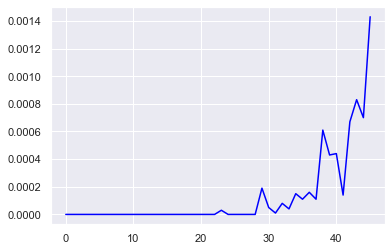

In [7]:
plt.plot(i_beta_22_08, color='blue')

In [8]:
scio.savemat('./i_beta_22_08.mat', {'i_beta_22_08': i_beta_22_08})